In [89]:
from transformers import AutoModelForTokenClassification

# Will load LayoutLMv3ForTokenClassification
MODEL_PATH = "C:/Projects/IDP/watercare/model_output/23_11_03_03/checkpoint-150/"
model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH)

In [90]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained(MODEL_PATH, apply_ocr=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [91]:
# Load in image
from PIL import Image
import numpy as np
from pathlib import Path
from pdf2image import convert_from_path

FILE_PATH = Path("C:/Projects/IDP/watercare/dataset/pdfs/23_11_27.pdf")

images = convert_from_path(FILE_PATH)

# Open an image file
# IMAGE_PATH = Path("C:/Projects/IDP/watercare/dataset/images/20-1.png")
# image = Image.open(IMAGE_PATH, formats=['png'])
PDF_PAGE = 1
image = images[PDF_PAGE]

# Convert the image to a NumPy array
image_array = np.asarray(image)
img_width, img_height = image.size

In [92]:
import pytesseract
from idp.annotations.bbox_utils import normalize_box

def get_text_box_pairs(image):
    tesseract_output = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
    boxes = []
    texts = []
    for i, level_idx in enumerate(tesseract_output["level"]):
        if level_idx == 5:
            bbox = [tesseract_output["left"][i],
                    tesseract_output["top"][i],
                    tesseract_output["left"][i]+tesseract_output["width"][i],
                    tesseract_output["top"][i]+tesseract_output["height"][i]
            ]
            if not tesseract_output["text"][i].strip():
                continue
            bbox = normalize_box(bbox, img_width, img_height)
            texts.append(tesseract_output["text"][i])
            boxes.append(bbox)

    return (texts, boxes)

texts, boxes = get_text_box_pairs(image)

In [93]:
# import csv

# with open('testFile.csv','w') as file:
#     for key in tesseract_output.keys():
#          file.write("%s, %s\n" % (key, tesseract_output[key]))

In [94]:
from pathlib import Path
import re

def is_box_a_within_box_b(box_a, box_b):
    left_a, top_a, right_a, bottom_a = box_a
    left_b, top_b, right_b, bottom_b = box_b
    
    # Check if Box B contains box A
    return left_b<=left_a and top_b<=top_a and right_b>=right_a and bottom_b>=bottom_a
    
# HACK remove texts & boxes outside of Labelling area
image_name = IMAGE_PATH.name
FIRST_PAGE = False
def text_box_relevant(text_box_pairs):
    text, box = text_box_pairs
    if FIRST_PAGE:
        outer_box = normalize_box((1298, 828, 1536, 1550), img_width, img_height)
        return is_box_a_within_box_b(box, outer_box)
    else:
        outer_box = normalize_box((139, 119, 827, 1173), img_width, img_height)
        return is_box_a_within_box_b(box, outer_box)
    
filtered_list = list(filter(text_box_relevant, list(zip(texts,boxes))))
result = [[text for text, box in filtered_list],[box for text, box in filtered_list]]
texts, boxes = result

In [95]:
texts, boxes

(['Details',
  'Charge',
  'details',
  'Consumption',
  'charges',
  'Unit',
  'rate',
  'Water',
  '22.00',
  'kL',
  '$1.998/kL',
  '$',
  '43.96',
  'Wastewater',
  '17.27',
  'kL',
  '$3.476/kL',
  '$',
  '60.03',
  '$',
  '103.99',
  'Consumption',
  'details',
  'Meter',
  'no.',
  'X19A613028',
  '-',
  'Consumption',
  'period',
  '30',
  'days',
  'This',
  'reading',
  '24-Nov-23',
  '781',
  'Actual',
  'Last',
  'reading',
  '25-Oct-23',
  '759',
  'Estimate',
  'Consumption',
  '22.00kL',
  'Water',
  '22.00kL',
  'Wastewater',
  '@78.50%',
  '17.27kL'],
 [[106, 63, 179, 76],
  [109, 88, 157, 98],
  [163, 88, 205, 96],
  [109, 100, 194, 109],
  [199, 100, 249, 109],
  [321, 100, 346, 107],
  [351, 100, 374, 107],
  [106, 109, 144, 122],
  [263, 111, 295, 118],
  [301, 111, 313, 118],
  [321, 111, 379, 119],
  [427, 111, 433, 119],
  [437, 111, 471, 118],
  [108, 119, 179, 133],
  [264, 122, 295, 129],
  [301, 122, 313, 129],
  [321, 121, 379, 129],
  [427, 121, 433, 129],

In [96]:
encoding = processor(images=[image_array], text=texts, boxes=boxes, return_tensors="pt")

In [97]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

In [98]:
outputs

TokenClassifierOutput(loss=None, logits=tensor([[[ 0.5304, -0.6172, -0.3139,  ..., -0.2395,  0.2582, -0.1597],
         [ 6.8312, -0.3943, -0.5311,  ..., -0.1877, -0.1720, -0.4352],
         [ 6.8402, -0.4031, -0.5497,  ..., -0.1776, -0.2078, -0.4014],
         ...,
         [ 6.7072, -0.3617, -0.7190,  ..., -0.0946, -0.2051, -0.2267],
         [ 6.7314, -0.3532, -0.7067,  ..., -0.1229, -0.2340, -0.2167],
         [ 0.5343, -0.6152, -0.3120,  ..., -0.2413,  0.2580, -0.1607]]]), hidden_states=None, attentions=None)

In [99]:
logits = outputs.logits
logits.shape

torch.Size([1, 109, 12])

In [100]:
predictions = logits.argmax(-1).squeeze().tolist()

In [101]:
predictions

[8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8]

In [102]:
model.config.id2label

{0: 'B-OTHER',
 1: 'B-BALANCE_STILL_OWING',
 2: 'B-WATER_CONSUMPTION',
 3: 'B-WASTEWATER_CONSUMPTION',
 4: 'B-WASTEWATER_FIXED',
 5: 'B-BALANCE_CURRENT_CHARGES',
 6: 'B-TOTAL_DUE',
 7: 'B-WATER_CONSUMPTION_DETAILS',
 8: 'B-WASTEWATER_CONSUMPTION_DETAILS',
 9: 'B-WASTEWATER_FIXED_DETAILS',
 10: 'B-THIS_READING',
 11: 'B-LAST_READING'}

In [103]:
from idp.annotations.bbox_utils import unnormalize_box, merge_box_extremes
from idp.annotations.annotation_utils import Classes, CLASS_TO_LABEL_MAP


token_boxes = encoding.bbox.squeeze().tolist()

input_id_list = encoding['input_ids'].squeeze()
true_predictions = [model.config.id2label[pred] for pred in predictions]
true_boxes = [unnormalize_box(box, img_width, img_height) for box in token_boxes]
true_texts = [processor.tokenizer.decode([input_id_list[i]]) for i in list(range(len(predictions)))]
    
output_dict = {value: {'text':'','box':[]} for key,value in CLASS_TO_LABEL_MAP.items() if key != Classes.OTHER}
for key in output_dict.keys():
    output_dict[key]['text'] = ''.join([ text for text, prediction in zip(true_texts, true_predictions) if prediction == key])
    output_dict[key]['box'] = merge_box_extremes([box for box, prediction in zip(true_boxes, true_predictions) if prediction == key])
    
#trim empty outputs
item_not_empty = lambda item : len(item[1]['text']) != 0
output_dict = dict(filter(item_not_empty, output_dict.items()))
output_dict

{'B-WATER_CONSUMPTION_DETAILS': {'text': ' Water 22.00 kL $1.998/kL $ 43.96',
  'box': [175, 254, 778, 285]},
 'B-WASTEWATER_CONSUMPTION_DETAILS': {'text': '<s> Wastewater 17.27 kL $3.476/kL $ 60.03</s>',
  'box': [0, 0, 778, 311]},
 'B-THIS_READING': {'text': ' This reading 24-Nov-23 781 Actual',
  'box': [178, 481, 798, 502]},
 'B-LAST_READING': {'text': ' Last reading 25-Oct-23 759 Estimate',
  'box': [180, 502, 798, 530]}}

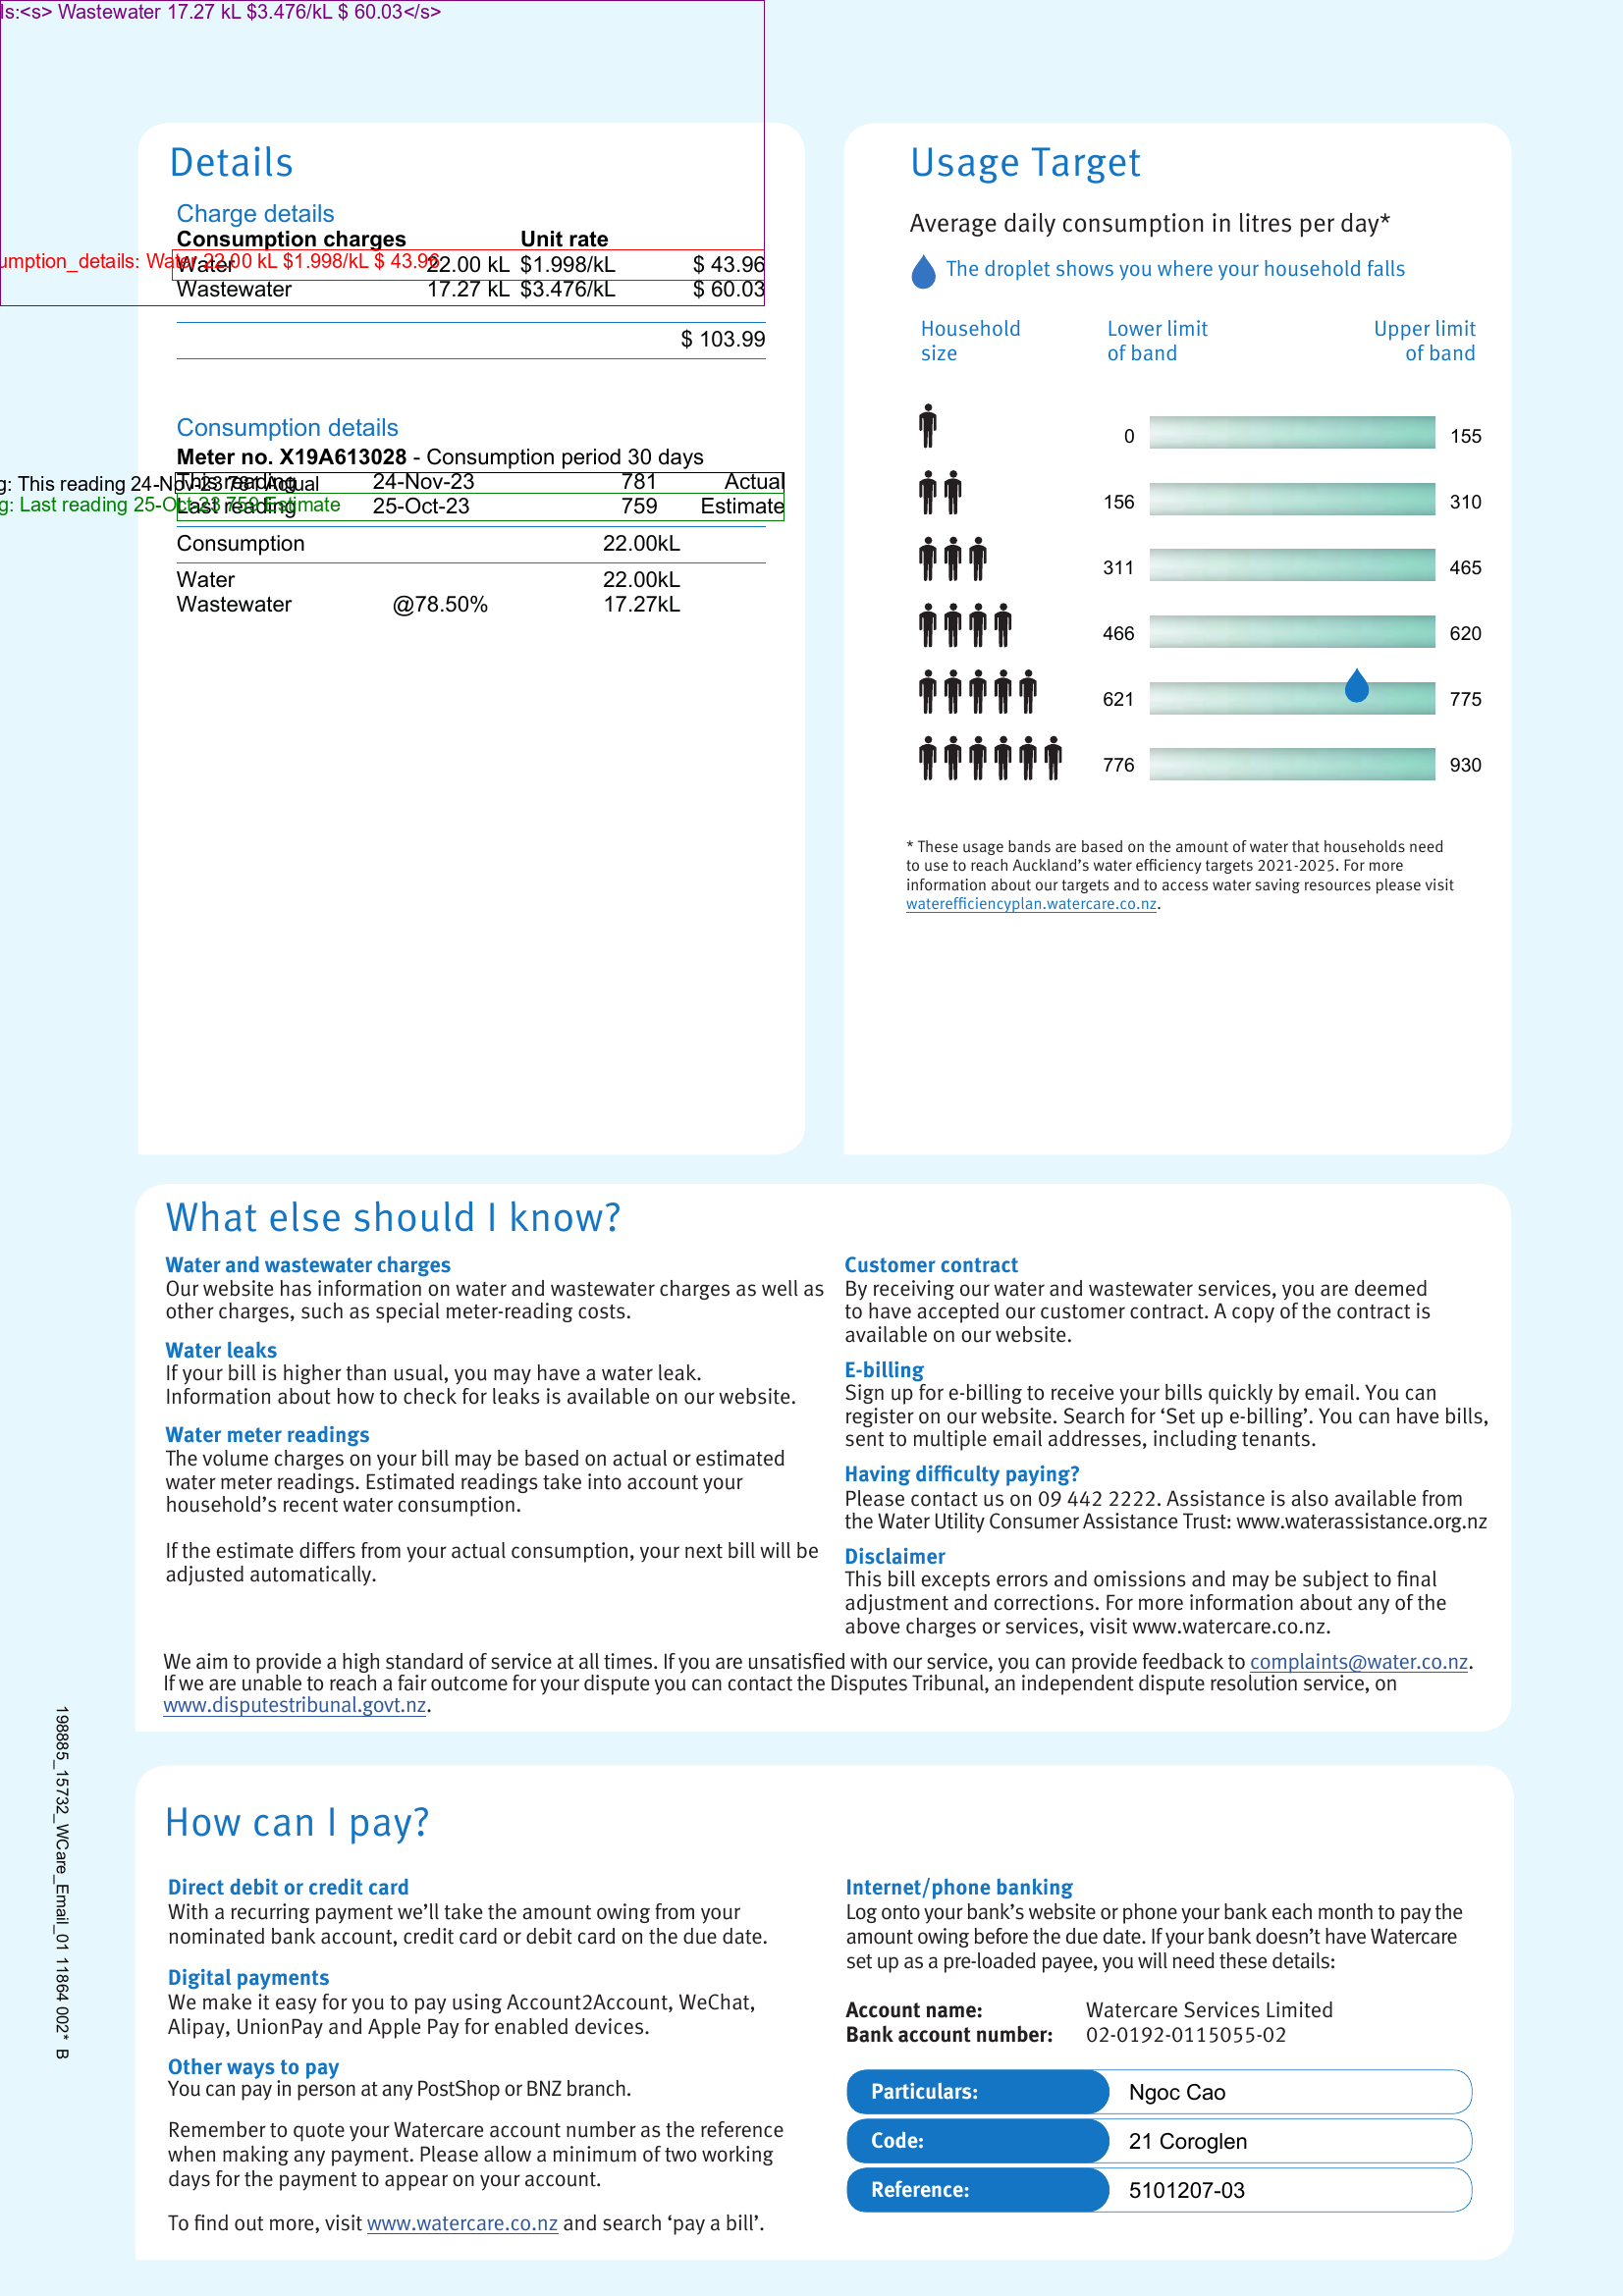

In [105]:
from PIL import ImageDraw, ImageFont

image = images[PDF_PAGE]
draw = ImageDraw.Draw(image)

# font = ImageFont.load_default()
font = ImageFont.truetype("arial.ttf", 20)

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'other':'pink','balance_still_owing':'red', 'water_consumption':'purple', 'wastewater_consumption':'green', 'wastewater_fixed':'orange', 'balance_current_charges':'violet',
              "total_due": "black",'water_consumption_details':'red','wastewater_consumption_details':'purple','wastewater_fixed_details':'green','her':'black','this_reading': 'black', 'last_reading': 'green'}

# for prediction, box in zip(true_predictions, true_boxes):
#     predicted_label = iob_to_label(prediction).lower()
#     draw.rectangle(box, outline=label2color[predicted_label])
#     draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)
    
for item in output_dict.items():
    predicted_label = iob_to_label(item[0]).lower()
    box = item[1]['box']
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] - 280, box[1]), text=f"{predicted_label}:{item[1]['text']}", fill=label2color[predicted_label], font=font)
    
image